In [1]:
from baseline_cnn import *
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as func
import torch.nn.init as torch_init
import torch.optim as optim

# Data utils and dataloader
import torchvision
from torchvision import transforms, utils
import matplotlib.pyplot as plt

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [3]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA NOT supported


## Load Train, Validation and Test data

In [4]:
transform = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor()])
dataset = loader('train.csv','./datasets/cs154-fa19-public/',transform=transform)
testdataset = loader("test.csv", './datasets/cs154-fa19-public/', transform=transform)

batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
# indices = list(range((int)(dataset_size/4))) # smmall part for experiments 
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size,
                                        shuffle=False)

# Make a weighted sampler - WIP

In [14]:
len(dataset)

30030

In [ ]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight   

# For unbalanced dataset we create a weighted sampler                       
#weights = make_weights_for_balanced_classes(dataset.imgs, len(dataset.classes))                                                                
#weights = torch.DoubleTensor(weights)                                       
#sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))  

## Show a sample from the dataset

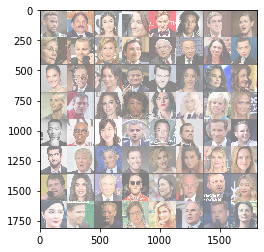

tensor([ 38,  91,  93,  66, 163, 138, 174, 189, 132,  76,  28, 102, 106,  11,
         72, 173,  24,  11,  33, 149, 137,  95,  22,  66, 198,  61,  22, 123,
        189, 122,  85, 164, 194, 172, 124, 177, 141,  76,  64,  40, 157,  34,
        131,  27, 192,  22,  21, 153, 137, 161,  57, 126,   7, 106, 127,  74,
         18,  27, 110, 168, 192,  50, 137,  66])


In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next() # We get batch_size number of images by calling .next()

# Places the images in a grid
imshow(torchvision.utils.make_grid(images))
print(labels)

## Create the network

In [6]:
net=Nnet().to(computing_device)
net.apply(weights_init)
print(net)

Nnet(
  (main): Sequential(
    (0): Conv2d(3, 21, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(21, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(20, 15, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(15, 7, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=1183, out_features=300, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=300, out_features=201, bias=True)
  )
)


## Define the Lossfunction and the Optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
# Pass the weights of the network (net.parameters) to the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0005) 

## Train the network

In [12]:
# Track the loss across training
train_epoch_losses = []
validation_epoch_losses = []
train_batch_losses = []
validation_batch_losses = []
avg_minibatch_loss = []
N = 50 # Intervall of average minibatch loss reporting.
n_epochs = 3
PATH = "./cnn_celeb.pth"  # Where to save the model

for epoch in range(n_epochs):
    N_minibatch_loss = 0.0

    # Get the next minibatch of images, labels for training
    for minibatch_count, (images, labels) in enumerate(train_loader, 0):
        fraction_done = round(minibatch_count/len(dataset)*100, 3)
        print("{} percent of epoch {} complete".format(fraction_done, epoch + 1), end="\r")
        # Zero out the stored gradient (buffer) from the previous iteration
        optimizer.zero_grad()
        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device)
        # Perform the forward pass through the network and compute the loss
        outputs = net(images)

        loss = criterion(outputs, labels) # If we are using Cross Entropy, this is doing Softmax
        # Automagically compute the gradients and backpropagate the loss through the network
        loss.backward()

        # Update the weights
        optimizer.step()
        # Add this iteration's loss to the total_loss
        train_batch_losses.append(loss.item())
        N_minibatch_loss += loss

        if minibatch_count % N == 49:
            # Print the loss averaged over the last N mini-batches
            N_minibatch_loss /= N
            print('Epoch %d, average minibatch %d loss: %.3f' % (epoch + 1, minibatch_count + 1, N_minibatch_loss))
            # Add the averaged loss over N minibatches and reset the counter
            avg_minibatch_loss.append(N_minibatch_loss)
            N_minibatch_loss = 0.0

    print("Finished", epoch + 1, "epochs of training")
    print("Saving model...")
    torch.save(net.state_dict(), PATH)
    print("Done.")

    # save train loss
    train_epoch_loss = np.average(np.array(train_batch_losses))
    train_batch_losses = []
    train_epoch_losses.append(train_epoch_loss)

    with torch.no_grad():
        # validation implementation
        for minibatch_count, (images, labels) in enumerate(validation_loader, 0):
            # Put the validation minibatch data in CUDA Tensors and run on the GPU if supported
            images, labels = images.to(computing_device), labels.to(computing_device)
            # Perform the forward pass through the network and compute the loss
            outputs = net(images)

            validation_batch_loss = criterion(outputs, labels)
            validation_batch_losses.append(validation_batch_loss)

        epoch_validation_loss = np.average(np.array(validation_batch_losses))
        validation_batch_losses = []
        validation_epoch_losses.append(epoch_validation_loss)

    print('Epoch %d, validation loss: %.3f' % (epoch + 1, epoch_validation_loss))

Epoch 1, average minibatch 50 loss: 4.433
Epoch 1, average minibatch 100 loss: 4.323


KeyboardInterrupt: 

## Test the model

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader: # Remember they come in batches
        # Since we are not doing this through criterion, we must add softmax our self
        outputs = func.softmax(net(images)) 
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Accuracy of the network on test images: 6 %


## Plot loss

[]
[]


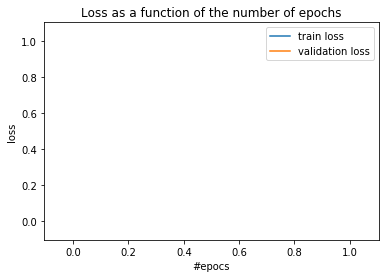

In [11]:
print(train_epoch_losses)
print(validation_epoch_losses)

plt.plot(train_epoch_losses, label="train loss")
plt.plot(validation_epoch_losses, label="validation loss")
plt.xlabel("#epocs")
plt.ylabel("loss")
plt.title("Loss as a function of the number of epochs")
plt.legend()
plt.show()


## Plot Weights

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

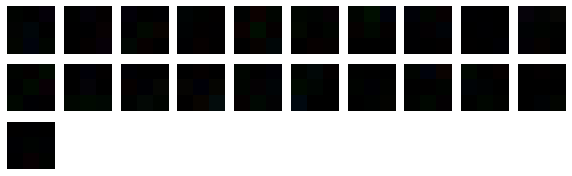

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

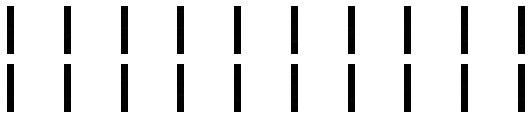

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

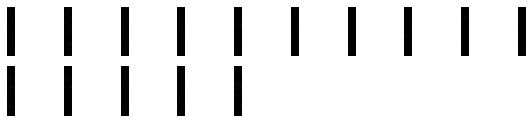

In [12]:
COLUMNS_IN_FIGURE = 10

def plot_weights(model, layer):
    weight_tensor = model.main._modules.get(str(layer)).weight.data

    if not weight_tensor.shape[-1] == 3:
        raise Exception("last dim needs to be 3")
    num_weights = weight_tensor.shape[0]
    num_rows = 1 + num_weights // COLUMNS_IN_FIGURE
    fig = plt.figure(figsize=(COLUMNS_IN_FIGURE, num_rows))
    for i in range(weight_tensor.shape[0]):
        sub = fig.add_subplot(num_rows, COLUMNS_IN_FIGURE, i + 1)
        sub.axis('off')
        sub.imshow(weight_tensor[i])
        sub.set_xticklabels([])
        sub.set_yticklabels([])

    plt.show()


plot_weights(net, 0)
plot_weights(net, 2)
plot_weights(net, 5)